# Welcome to Quantum Blackjack
### A Game of Superposition, Entanglement, and Strategy

This game introduces a unique twist on the classic game of Blackjack, infusing it with the fascinating principles of quantum mechanics. While the objective remains familiar—to get a hand value as close to **17** as possible without going over—the way you play is fundamentally different. Instead of a standard deck, you are dealt a combination of classical and "quantum" cards, transforming the game from one of simple chance into a strategic exercise in probability management.

---

## The Quantum Cards

At the heart of the game lies the concept of the quantum card. Unlike a classical card, which has a single, definite value, a quantum card exists in a state of **superposition**. 

This means it represents multiple possible values (from `1` to `8`) *at the same time*, each with a specific probability of being the final outcome. You can think of it not as a card with a hidden value, but as a cloud of potential values that will only collapse into a single, concrete number when a **measurement** occurs.

This game visualizes these odds for you, showing the initial probability distribution for each of your quantum cards.

## Key Quantum Principles in Your Hand

This game leverages three core quantum phenomena to create a unique strategic landscape:

* **Superposition and Probabilistic Strategy:** The initial state of your quantum cards is set by Hadamard (`H`) and rotation (`RY`) gates. This gives you a starting set of probabilities. Your key action, **`[H] Re-Shuffle`**, allows you to apply another Hadamard gate to one of your quantum cards, directly altering its probability distribution and allowing you to strategically manipulate your odds before committing to a measurement.

* **Entanglement - A Shared Fate:** The most intriguing feature of this game is **entanglement**. The quantum cards of Player 1 and Player 2 are linked using CNOT (`CX`) gates. This creates a deep, non-classical connection between them. The measurement outcome of one player's card will instantly influence the outcome of the other's. As the code's design implies, their results are correlated, meaning you aren't just playing against the dealer; you are in a quantum duel with the other player.

* **Measurement - The Collapse of Possibility:** The ultimate decision in the game is to **`[M]easure`**. This action forces the quantum system to collapse. At that moment, every quantum card in play—for you, the other player, and the dealer—simultaneously settles into a single, definite value. The timing of this measurement is the game's central strategic pivot. Do you measure early with a 2-card hand, or do you let the quantum state evolve, aiming for a 3-card hand but giving your opponent a chance to alter the entangled system?

---

In essence, this Quantum Blackjack challenges you to think beyond fixed odds. You must weigh probabilities, strategically modify them, and consider how your actions will ripple through the entangled state to affect your opponent, all before making the decisive choice to collapse the quantum wave function and reveal your final hand.

In [7]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
import numpy as np
import random
from typing import List, Dict, Tuple
from IPython.display import display

In [8]:
# --- Game Constants ---
TARGET_SCORE = 17
DEALER_STANDS_THRESHOLD = 14
MIN_CARD_VALUE = 1
MAX_CARD_VALUE = 8
NUM_QUANTUM_CARDS_PER_PLAYER = 2

In [12]:
class QuantumCardGame:
    """
    Encapsulates the logic for a Quantum BlackJack.
    """

    def __init__(self):
        """Initializes the game, including the quantum simulator backend."""
        self.qc: QuantumCircuit = None
        self.dealer_q: QuantumRegister = None
        self.player1_q: QuantumRegister = None
        self.player2_q: QuantumRegister = None
        self.dealer_c: ClassicalRegister = None
        self.player1_c: ClassicalRegister = None
        self.player2_c: ClassicalRegister = None
        self.backend = AerSimulator()
        self.player_scores: Dict[str, int] = {}
        self.initial_cards: Dict[str, int] = {}

    def _generate_random_card(self) -> int:
        """Generates a random card with a value."""
        return np.random.randint(MIN_CARD_VALUE, MAX_CARD_VALUE + 1)

    def _get_card_value_from_binary(self, binary_string: str) -> int:
        """Converts a 3-bit binary string to an integer card value (1-8)."""
        return int(binary_string, 2) + 1

    def _determine_turn_order(self) -> List[int]:
        """Uses a quantum coin flip to fairly determine the player turn order."""
        coin_qc = QuantumCircuit(1, 1)
        coin_qc.h(0)
        coin_qc.measure(0, 0)
        job = self.backend.run(coin_qc, shots=1, memory=True)
        result = job.result().get_memory()[0]
        print(f"\nQuantum Coin Flip... Result: |{result}>")
        if result == '0':
            print("Player 1 plays first in this round.")
            return [1, 2]
        else:
            print("Player 2 plays first in this round.")
            return [2, 1]

    def _setup_game_environment(self):
        """Prints welcome messages and gets the initial cards for all players."""
        print("--- Welcome to the Quantum Card Game ---")
        print(f"Objective: Get a total card value as close to {TARGET_SCORE} as possible without exceeding it.")
        self.initial_cards["Dealer"] = self._generate_random_card()
        self.initial_cards["Player 1"] = self._generate_random_card()
        self.initial_cards["Player 2"] = self._generate_random_card()
        print("\n--- Initial Visible Cards ---")
        print(f"Dealer's visible card: {self.initial_cards['Dealer']}")
        print(f"Player 1's visible card: {self.initial_cards['Player 1']}")
        print(f"Player 2's visible card: {self.initial_cards['Player 2']}")

    def _apply_h_and_ry_and_print_dist(self, qubits: List, card_name: str):
        """
        Helper method to apply H and RY gates to a set of qubits and print
        the resulting probability distribution.
        """
        self.qc.h(qubits)
        rotation_angles = []
        for qubit in qubits:
            angle = np.random.uniform(0, 2 * np.pi)
            self.qc.ry(angle, qubit)
            rotation_angles.append(angle)

        temp_qc = QuantumCircuit(3)
        temp_qc.h(range(3))
        for i, angle in enumerate(rotation_angles):
            temp_qc.ry(angle, i)

        state = Statevector.from_instruction(temp_qc)
        probabilities = state.probabilities()

        print(f"\nDistribution for {card_name}:")
        for i, p in enumerate(probabilities):
            card_value = i + 1
            print(f"  - Card Value {card_value}: {p:.2%}")

    def _prepare_player_cards_with_rotations(self):
        """
        Prepares Player 1's cards by applying Hadamard gates followed by
        random RY rotation gates to create a non-uniform distribution.
        """
        print("-- Player Quantum Card Initial Probabilities (via H + RY Gates)")
        print("This is the initial probability distribution for Player 1's quantum cards.")
        print("Due to entanglement, Player 2's cards will have a related (but reversed) outcome upon measurement.")

        self._apply_h_and_ry_and_print_dist(self.player1_q[3:6], "Quantum Card 1")
        self.qc.barrier()
        self._apply_h_and_ry_and_print_dist(self.player1_q[0:3], "Quantum Card 2")

    def _prepare_quantum_circuit(self):
        """
        Prepares the main quantum circuit for the game using H+RY gates for players.
        """
        num_qubits = NUM_QUANTUM_CARDS_PER_PLAYER * 3
        self.dealer_q = QuantumRegister(num_qubits, 'dealer')
        self.player1_q = QuantumRegister(num_qubits, 'player1')
        self.player2_q = QuantumRegister(num_qubits, 'player2')
        self.dealer_c = ClassicalRegister(num_qubits, 'dealer_res')
        self.player1_c = ClassicalRegister(num_qubits, 'player1_res')
        self.player2_c = ClassicalRegister(num_qubits, 'player2_res')

        self.qc = QuantumCircuit(self.dealer_q, self.player1_q, self.player2_q,
                                 self.dealer_c, self.player1_c, self.player2_c)
        self.qc.barrier()

        print("--- Preparing Quantum Deck ---")
        print("Dealer's cards are being shuffled into a uniform superposition.")
        self.qc.h(self.dealer_q)
        self.qc.barrier()

        self._prepare_player_cards_with_rotations()
        self.qc.barrier()

        self.qc.cx(self.player1_q[3], self.player2_q[5])
        self.qc.cx(self.player1_q[4], self.player2_q[4])
        self.qc.cx(self.player1_q[5], self.player2_q[3])
        self.qc.barrier()

        self.qc.cx(self.player1_q[0], self.player2_q[2])
        self.qc.cx(self.player1_q[1], self.player2_q[1])
        self.qc.cx(self.player1_q[2], self.player2_q[0])
        self.qc.barrier()

    def _apply_player_gate(self, player_num: int, action: str):
        player_q = self.player1_q if player_num == 1 else self.player2_q
        card_choice = ''
        while card_choice not in ['1', '2']:
            card_choice = input(f"Apply to which quantum card (1 or 2)? ")
        qubits_to_affect = player_q[3:6] if card_choice == '1' else player_q[0:3]
        if action == 'H':
            print(f"Player {player_num} chose to [H] Re-Shuffle quantum card {card_choice}, applying a Hadamard gate.")
            self.qc.h(qubits_to_affect)
        self.qc.barrier()

    def _player_action_round(self, round_title: str) -> bool:
        print(f"\n--- {round_title} ---")
        player_turn_order = self._determine_turn_order()
        action_prompt = "[M]easure, [P]ass, [H] Re-Shuffle? "
        for player_num in player_turn_order:
            action = ''
            while action not in ['M', 'P', 'H']:
                action = input(f"Player {player_num}, choose your quantum action: {action_prompt}").upper()
            if action == 'M':
                print(f"\nPlayer {player_num} chose to [M]easure. The quantum state will collapse!")
                return False
            elif action == 'P':
                print(f"Player {player_num} chose to [P]ass.")
                continue
            else:
                self._apply_player_gate(player_num, action)
        return True

    def _play_rounds(self) -> int:
        if not self._player_action_round("Round 1: Play for 2 or 3 Cards?"):
            return 2
        if not self._player_action_round("Round 2: Final Decision on 3-Card Hand"):
            return 3
        print("\nAll players passed the final round. The final 3-card hands will be revealed.")
        return 3

    def _add_measurements_to_circuit(self, measure_level: int):
        print("\nLocking in final results... Collapsing quantum states...")
        if measure_level == 2:
            print("Measuring first quantum cards only...")
            self.qc.measure(self.dealer_q[3:6], self.dealer_c[3:6])
            self.qc.measure(self.player1_q[3:6], self.player1_c[3:6])
            self.qc.measure(self.player2_q[3:6], self.player2_c[3:6])
        else:
            print("Measuring all quantum cards...")
            self.qc.measure(self.dealer_q, self.dealer_c)
            self.qc.measure(self.player1_q, self.player1_c)
            self.qc.measure(self.player2_q, self.player2_c)

    def _execute_circuit(self) -> str:
        print("\n--- Final Quantum Circuit to be Executed ---")
        style = {'figwidth': 20, 'subfontsize': 9, 'displaycolor': {'ry': ('#f0ad4e', '#ffffff'), 'cx': ('#337ab7', '#ffffff'), 'h': ('#5cb85c', '#ffffff'), 'measure': ('#d9534f', '#ffffff')}}
        circuit_diagram = self.qc.draw(output='mpl', style=style, fold=-1)
        display(circuit_diagram)
        transpiled_qc = transpile(self.qc, self.backend)
        job = self.backend.run(transpiled_qc, shots=1, memory=True)
        result_str = job.result().get_memory()[0]
        print(f"\nMeasurement Result from Registers (P2, P1, Dealer): {result_str}")
        return result_str

    def _process_results(self, result_str: str, measure_level: int):
        results_list = result_str.split(' ')
        if len(results_list) != 3:
            print(f"Error: Expected 3 register results, but got {len(results_list)}. Full string: '{result_str}'")
            self.player_scores = {"Player 1": 0, "Player 2": 0, "Dealer": 0}
            return
        p2_res, p1_res, dealer_res = results_list
        player_hands = { "Player 1": [self.initial_cards["Player 1"]], "Player 2": [self.initial_cards["Player 2"]], "Dealer": [self.initial_cards["Dealer"]] }
        p1_q1 = self._get_card_value_from_binary(p1_res[0:3][::-1]); player_hands["Player 1"].append(p1_q1)
        p2_q1 = self._get_card_value_from_binary(p2_res[0:3][::-1]); player_hands["Player 2"].append(p2_q1)
        d_q1 = self._get_card_value_from_binary(dealer_res[0:3][::-1]); player_hands["Dealer"].append(d_q1)
        if measure_level == 3:
            p1_q2 = self._get_card_value_from_binary(p1_res[3:6][::-1]); player_hands["Player 1"].append(p1_q2)
            p2_q2 = self._get_card_value_from_binary(p2_res[3:6][::-1]); player_hands["Player 2"].append(p2_q2)
            if sum(player_hands["Dealer"]) < DEALER_STANDS_THRESHOLD:
                print(f"Dealer's current total ({sum(player_hands['Dealer'])}) is less than {DEALER_STANDS_THRESHOLD}, so they must take their second quantum card.")
                d_q2 = self._get_card_value_from_binary(dealer_res[3:6][::-1]); player_hands["Dealer"].append(d_q2)
            else:
                 print(f"Dealer's current total ({sum(player_hands['Dealer'])}) is {DEALER_STANDS_THRESHOLD} or more, so they stand and do not take their second quantum card.")
        for p in player_hands: self.player_scores[p] = sum(player_hands[p])
        print("--- Revealed Hands ---")
        for player, cards in player_hands.items():
            cards_str = " + ".join(map(str, cards))
            print(f"{player}: {cards_str} = {self.player_scores[player]}")
        self._dealer_final_turn(self.player_scores["Dealer"])

    def _dealer_final_turn(self, current_dealer_total: int):
        while current_dealer_total < DEALER_STANDS_THRESHOLD:
            new_card_val = self._generate_random_card()
            print(f"\nDealer total is {current_dealer_total} (<{DEALER_STANDS_THRESHOLD}). Dealer MUST draw a classical card.")
            print(f"Dealer draws a {new_card_val}.")
            current_dealer_total += new_card_val
        self.player_scores["Dealer"] = current_dealer_total
        print(f"Dealer's Final Total: {self.player_scores['Dealer']}")

    def _determine_winner(self):
        print("--- GAME OUTCOME ---")
        valid_scores = {}
        for player, score in self.player_scores.items():
            if score > TARGET_SCORE:
                print(f"{player} BUSTED with a score of {score}!")
            else:
                valid_scores[player] = score
        if not valid_scores:
            print("Everyone busted! The house wins.")
        else:
            max_score = max(valid_scores.values())
            winners = [player for player, score in valid_scores.items() if score == max_score]
            if len(winners) > 1:
                print(f"\nIt's a TIE between: {', '.join(winners)} with a score of {max_score}!")
            else:
                print(f"\nCONGRATULATIONS! {winners[0]} wins with a score of {max_score}!")

    def play(self):
        self._setup_game_environment()
        self._prepare_quantum_circuit()
        measure_level = self._play_rounds()
        self._add_measurements_to_circuit(measure_level)
        result_str = self._execute_circuit()
        self._process_results(result_str, measure_level)
        self._determine_winner()

--- Welcome to the Quantum Card Game ---
Objective: Get a total card value as close to 17 as possible without exceeding it.

--- Initial Visible Cards ---
Dealer's visible card: 8
Player 1's visible card: 4
Player 2's visible card: 4
--- Preparing Quantum Deck ---
Dealer's cards are being shuffled into a uniform superposition.
-- Player Quantum Card Initial Probabilities (via H + RY Gates)
This is the initial probability distribution for Player 1's quantum cards.
Due to entanglement, Player 2's cards will have a related (but reversed) outcome upon measurement.

Distribution for firs card of Player Quantum Card 1:
  - Card Value 1: 6.17%
  - Card Value 2: 0.19%
  - Card Value 3: 3.31%
  - Card Value 4: 0.10%
  - Card Value 5: 56.97%
  - Card Value 6: 1.78%
  - Card Value 7: 30.53%
  - Card Value 8: 0.95%

Distribution for firs card of Player Quantum Card 2:
  - Card Value 1: 54.91%
  - Card Value 2: 2.69%
  - Card Value 3: 9.99%
  - Card Value 4: 0.49%
  - Card Value 5: 25.74%
  - Card 

Player 2, choose your quantum action: [M]easure, [P]ass, [H] Re-Shuffle?  P


Player 2 chose to [P]ass.


Player 1, choose your quantum action: [M]easure, [P]ass, [H] Re-Shuffle?  P


Player 1 chose to [P]ass.

--- Round 2: Final Decision on 3-Card Hand ---

Quantum Coin Flip... Result: |1>
Player 2 plays first in this round.


Player 2, choose your quantum action: [M]easure, [P]ass, [H] Re-Shuffle?  H
Apply to which quantum card (1 or 2)?  2


Player 2 chose to [H] Re-Shuffle quantum card 2, applying a Hadamard gate.


Player 1, choose your quantum action: [M]easure, [P]ass, [H] Re-Shuffle?  M



Player 1 chose to [M]easure. The quantum state will collapse!

Locking in final results... Collapsing quantum states...
Measuring all quantum cards...

--- Final Quantum Circuit to be Executed ---


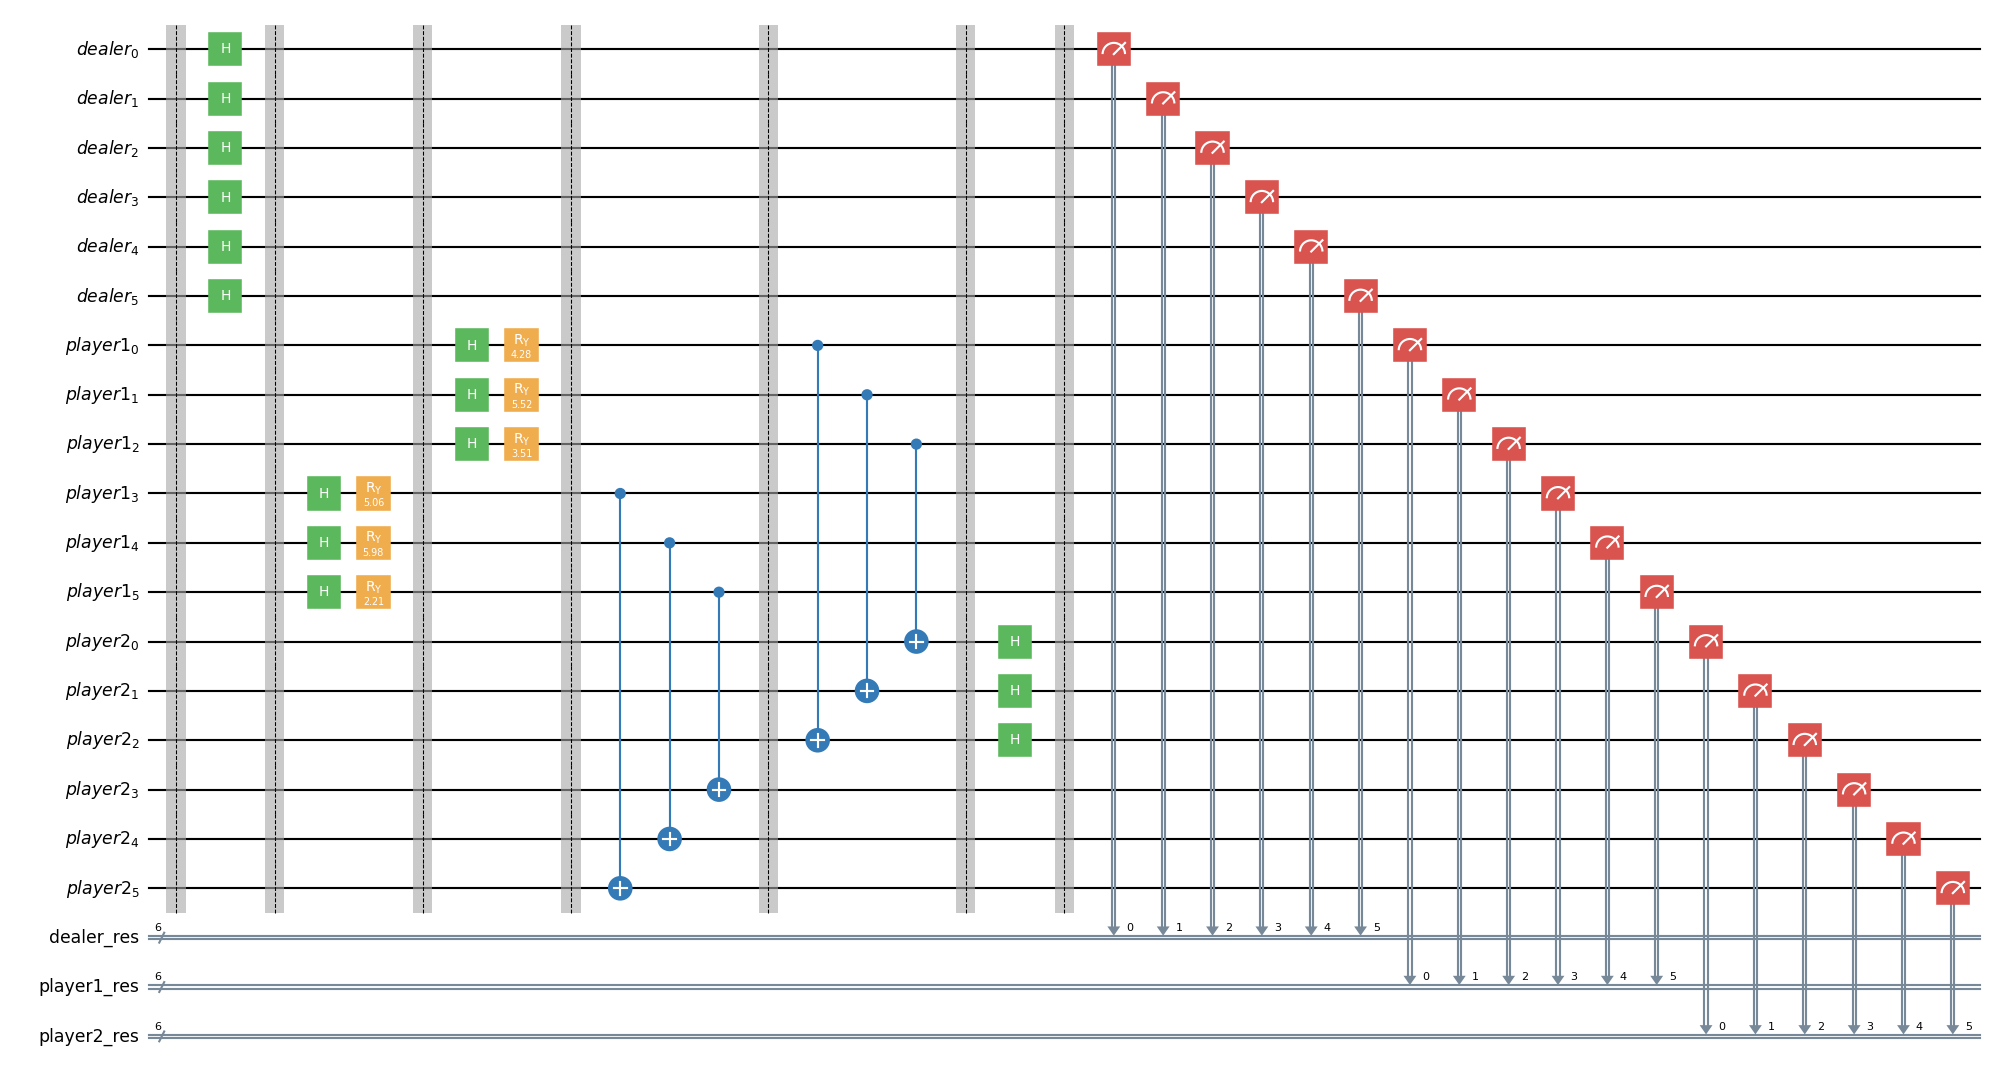


Measurement Result from Registers (P2, P1, Dealer): 001111 100000 010111
Dealer's current total (11) is less than 14, so they must take their second quantum card.
--- Revealed Hands ---
Player 1: 4 + 2 + 1 = 7
Player 2: 4 + 5 + 8 = 17
Dealer: 8 + 3 + 8 = 19
Dealer's Final Total: 19
--- GAME OUTCOME ---
Dealer BUSTED with a score of 19!

CONGRATULATIONS! Player 2 wins with a score of 17!


In [13]:
game = QuantumCardGame()
game.play()

______